In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [2]:
import os
import pandas as pd

# set the directory path where the csv files are located
dir_path = './'

# get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# create an empty dictionary to store the dataframes
dfs = {}

# loop through each csv file and read it into a dataframe
for file in csv_files:
    # get the name of the file without the extension
    name = file.split('.')[0]
    # read the csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))
    # add the dataframe to the dictionary with the file name as the key
    dfs[name] = df

In [3]:
# Print the shape of the dataset
weather_data = dfs['weather_data']
sensor_readings = dfs['sensor_readings']
leak_locations_and_rate = dfs['leak_locations_and_rate']
curr_df = weather_data
print("Shape of the dataset: ", curr_df.shape)

Shape of the dataset:  (86401, 6)


In [4]:
time_classification_map = {}
for index, row in leak_locations_and_rate.iterrows():
    for i in range(row['tStart'], row['tEnd'] + 1):
        time_classification_map[i] = True

def get_leak_location_and_rate(time):
    return time_classification_map.get(time, False)

In [5]:
def locationStandarizer(leakLocations):
    leakLocations['Longitude'] = (leakLocations['Longitude'] - leakLocations['Longitude'].mean())/leakLocations['Longitude'].std()
    leakLocations['Latitude'] = (leakLocations['Latitude'] - leakLocations['Latitude'].mean())/leakLocations['Latitude'].std()

In [6]:
# convert timestamp to POSIX time format
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])
weather_data['timestamp'] = weather_data['timestamp'].apply(lambda x: x.timestamp())
# change the data type of the timestamp column to int
weather_data['timestamp'] = weather_data['timestamp'].astype(int)

In [7]:
weather_data.set_index('timestamp', inplace=True)

In [8]:
# average all rows with same timestamp
weather_data = weather_data.groupby('timestamp').mean()

In [9]:
# create a numpy array with the same shape as detection_input
data = np.empty((24*86401, 10), dtype=object)

# loop through each row in sensor_readings dataframe
outer_index = 0
for index, row in sensor_readings.iterrows():
    # loop through each sensor in the row
    for col in sensor_readings.columns:
        if col not in ['Unnamed: 0', 'time']:
            longitude = col.split('_')[1]
            latitude = col.split('_')[2]
            value = row[col]
            leak_probability = 0 if get_leak_location_and_rate(row['time']) else 1
            #find weather data based on the minute of the timestamp
            weather_data_row = weather_data.loc[int(row['time'] // 60 * 60)]
            
            #unpack weather data
            temperature = weather_data_row['Temperature']
            humidity = weather_data_row['Humidity']
            pressure = weather_data_row['Barometric_Pressure']
            wind_direction = weather_data_row['Wind_Direction']
            wind_speed = weather_data_row['Wind_Speed']
    
            data[outer_index] = [row['time'], latitude, longitude, value, leak_probability, temperature, humidity, pressure, wind_direction, wind_speed]
            outer_index += 1
            
    if index % 10000 == 0:
        print(index)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [13]:
data

array([[1681776002.0, nan, nan, ..., 827.0620896, 320.56899132166666,
        1.7845848806666667],
       [1681776002.0, nan, nan, ..., 827.0620896, 320.56899132166666,
        1.7845848806666667],
       [1681776002.0, nan, nan, ..., 827.0620896, 320.56899132166666,
        1.7845848806666667],
       ...,
       [None, nan, nan, ..., None, None, None],
       [None, nan, nan, ..., None, None, None],
       [None, nan, nan, ..., None, None, None]], dtype=object)

In [64]:
# create the dataframe from the numpy array
detection_input = pd.DataFrame(data, columns=['time', 'latitude', 'longitude', 'value', 'leak_probability', 'temperature', 'humidity', 'pressure', 'wind_direction', 'wind_speed'])

# print the new dataframe
print(detection_input.head())

           time  latitude longitude   value leak_probability temperature  \
0  1681776002.0 -1.618287 -1.097255  1030.0                1   10.737401   
1  1681776002.0  -1.69663  1.231353  1049.0                1   10.737401   
2  1681776002.0 -0.476386 -1.118541  1166.0                1   10.737401   
3  1681776002.0  -0.49063  1.256895   964.0                1   10.737401   
4  1681776002.0  -1.69663  1.231353  1023.0                1   10.737401   

    humidity   pressure wind_direction wind_speed  
0  31.740852  827.06209     320.568991   1.784585  
1  31.740852  827.06209     320.568991   1.784585  
2  31.740852  827.06209     320.568991   1.784585  
3  31.740852  827.06209     320.568991   1.784585  
4  31.740852  827.06209     320.568991   1.784585  


In [62]:
# remove rows with all values none
detection_input = detection_input.dropna()

In [63]:
data = detection_input.to_numpy()

# normalize the longitude and latitude columns in the dataset
lat_mean = data[:,1].astype(float).mean()
long_mean = data[:,2].astype(float).mean()

lat_std = data[:,1].astype(float).std()
long_std = data[:,2].astype(float).std()

# print all stats
print("Latitude mean: ", lat_mean)
print("Latitude std: ", lat_std)
print("Longitude mean: ", long_mean)
print("Longitude std: ", long_std)

data[:, 1] = (data[:, 1].astype(float) - lat_mean) / lat_std
data[:, 2] = (data[:, 2].astype(float) - long_mean) / long_std

Latitude mean:  -105.13986833333317
Latitude std:  0.00042122724139034883
Longitude mean:  40.59581875000003
Longitude std:  0.0002349042801508659


In [65]:
# drop time column
detection_input = detection_input.drop(columns=['time'])

In [66]:
detection_input



,latitude,longitude,value,leak_probability,temperature,humidity,pressure,wind_direction,wind_speed
0,-1.618287,-1.097255,1030.0,1,10.737401,31.740852,827.06209,320.568991,1.784585
1,-1.69663,1.231353,1049.0,1,10.737401,31.740852,827.06209,320.568991,1.784585
2,-0.476386,-1.118541,1166.0,1,10.737401,31.740852,827.06209,320.568991,1.784585
3,-0.49063,1.256895,964.0,1,10.737401,31.740852,827.06209,320.568991,1.784585
4,-1.69663,1.231353,1023.0,1,10.737401,31.740852,827.06209,320.568991,1.784585
...,...,...,...,...,...,...,...,...,...
2001907,0.451854,1.184525,1019.0,1,11.388949,36.234596,822.476311,324.350733,8.866722
2001908,1.56052,-1.178139,953.0,1,11.388949,36.234596,822.476311,324.350733,8.866722
2001909,0.36639,-1.156854,1017.0,1,11.388949,36.234596,822.476311,324.350733,8.866722
2001910,1.719579,1.150469,846.0,1,11.388949,36.234596,822.476311,324.350733,8.866722


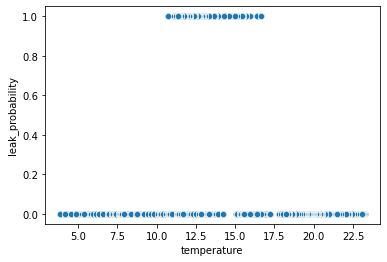

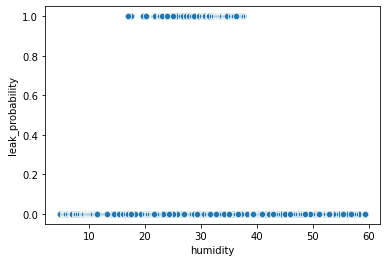

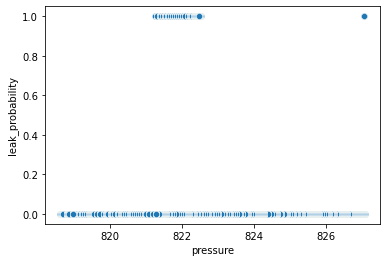

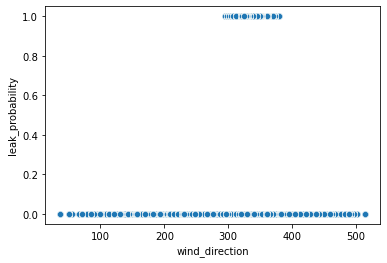

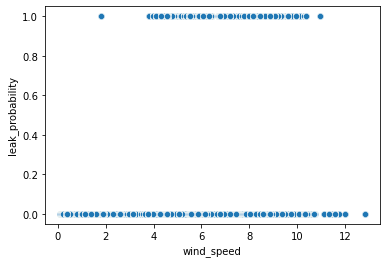

In [30]:
#visualize the weather and find correlations between weather and leak probability
sns.scatterplot(x='temperature', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='humidity', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='pressure', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='wind_direction', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='wind_speed', y='leak_probability', data=detection_input)
plt.show()


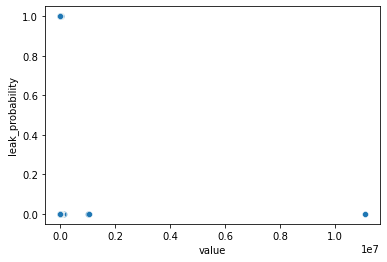

In [32]:
# visualize the coorelation between the values and leak probability
sns.scatterplot(x='value', y='leak_probability', data=detection_input)
plt.show()

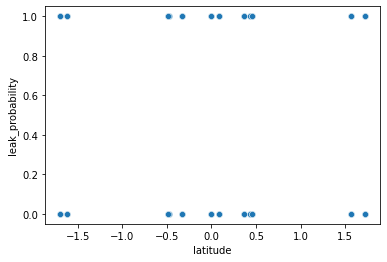

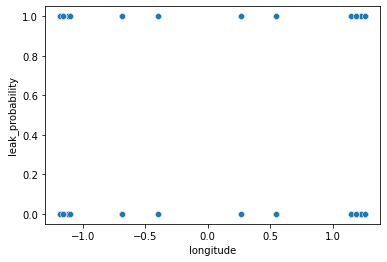

c:\Users\alex\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='leak_probability', ylabel='Density'>

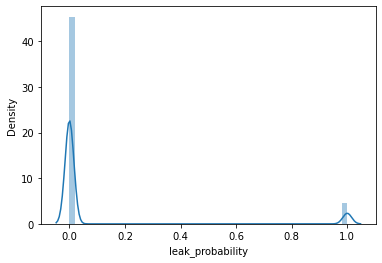

In [39]:
# visualize the coorelation between the longitude and latitude and leak probability
sns.scatterplot(x='latitude', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='longitude', y='leak_probability', data=detection_input)
plt.show()

#show the distribution of leak probability
sns.distplot(detection_input['leak_probability'])

In [40]:
# Check unique values in 'leak_probability' column
print(detection_input['leak_probability'].unique())

# If necessary, convert 'leak_probability' to numerical or categorical format
detection_input['leak_probability'] = detection_input['leak_probability'].astype('int')

[1 0]


Accuracy:  0.9939068228709002
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    181515
           1       0.99      1.00      0.99    181514

    accuracy                           0.99    363029
   macro avg       0.99      0.99      0.99    363029
weighted avg       0.99      0.99      0.99    363029



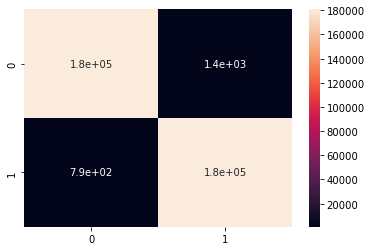

Accuracy:  0.9939674240900864
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    181514
           1       0.99      1.00      0.99    181515

    accuracy                           0.99    363029
   macro avg       0.99      0.99      0.99    363029
weighted avg       0.99      0.99      0.99    363029



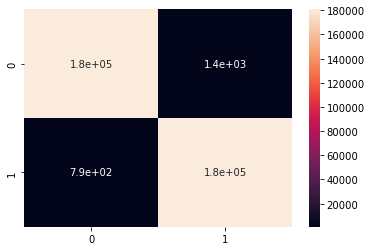

Accuracy:  0.9938076572395043
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    181515
           1       0.99      1.00      0.99    181514

    accuracy                           0.99    363029
   macro avg       0.99      0.99      0.99    363029
weighted avg       0.99      0.99      0.99    363029



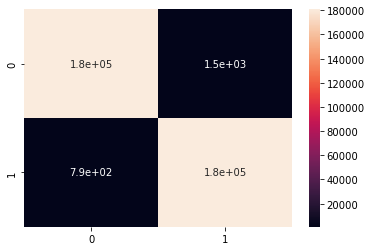

Accuracy:  0.9938682584586906
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    181514
           1       0.99      1.00      0.99    181515

    accuracy                           0.99    363029
   macro avg       0.99      0.99      0.99    363029
weighted avg       0.99      0.99      0.99    363029



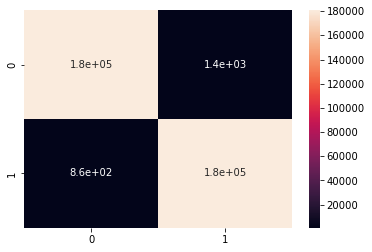

Accuracy:  0.9937112462089805
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    181514
           1       0.99      1.00      0.99    181515

    accuracy                           0.99    363029
   macro avg       0.99      0.99      0.99    363029
weighted avg       0.99      0.99      0.99    363029



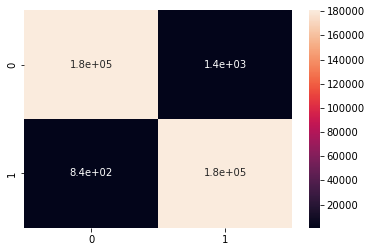

In [45]:
# train a naive bayes classifier on the data to see how well it can predict leak probability
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# define the number of folds
k = 5

# split x and y
X = detection_input.drop(columns=['leak_probability'])
y = detection_input['leak_probability']

# implement SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# create a KFold object
kf = StratifiedShuffleSplit(n_splits=k, random_state=None)

# remeber best model
best_model = None
best_model_accuracy = 0

# split the data into k folds
for train_index, test_index in kf.split(X, y):
    # get the training and testing data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train the decision tree classifier on the training data
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = clf.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    if accuracy > best_model_accuracy:
        best_model = clf
        best_model_accuracy = accuracy

    # print the classification report
    print(classification_report(y_test, y_pred))

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

In [46]:
# pickle the model
import pickle
filename = 'naive_bayes_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

Accuracy:  0.9998374785485457
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181515
           1       1.00      1.00      1.00    181514

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



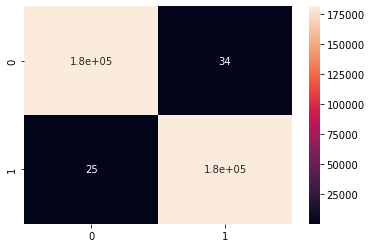

Accuracy:  0.9998650245572668
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181515
           1       1.00      1.00      1.00    181514

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



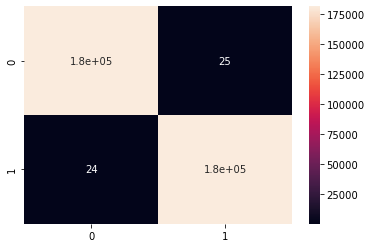

Accuracy:  0.9998512515529062
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181514
           1       1.00      1.00      1.00    181515

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



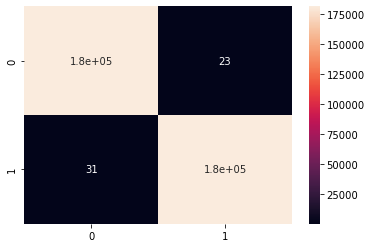

Accuracy:  0.9998898159651157
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181515
           1       1.00      1.00      1.00    181514

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



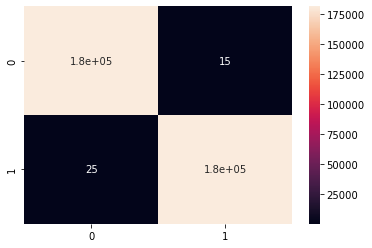

Accuracy:  0.999820950943313
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181515
           1       1.00      1.00      1.00    181514

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



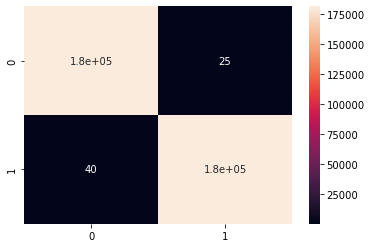

In [47]:
# train a decision tree classifier on the data to see how well it can predict leak probability
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# define the number of folds
k = 5

# split x and y
X = detection_input.drop(columns=['leak_probability'])
y = detection_input['leak_probability']

# implement SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# create a KFold object
kf = StratifiedShuffleSplit(n_splits=k, random_state=None)

# remeber best model
best_model = None
best_model_accuracy = 0

# split the data into k folds
for train_index, test_index in kf.split(X, y):
    # get the training and testing data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train the decision tree classifier on the training data
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = clf.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    if accuracy > best_model_accuracy:
        best_model = clf
        best_model_accuracy = accuracy

    # print the classification report
    print(classification_report(y_test, y_pred))

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

In [48]:
#pickle the model
import pickle
filename = 'decision_tree_model.sav'
pickle.dump(best_model, open(filename, 'wb'))



Accuracy:  0.9998071779389526
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181514
           1       1.00      1.00      1.00    181515

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



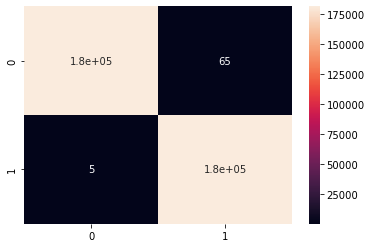

Accuracy:  0.9997906503337199
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181515
           1       1.00      1.00      1.00    181514

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



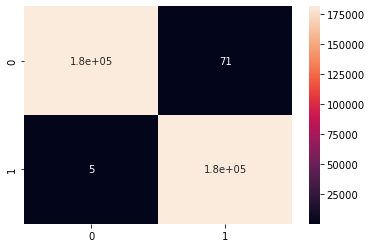

Accuracy:  0.9998319693468015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181514
           1       1.00      1.00      1.00    181515

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



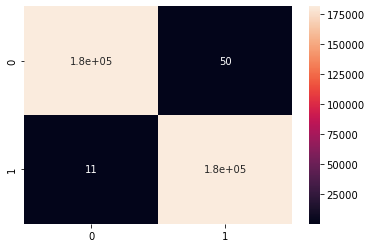

Accuracy:  0.9998237055441852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181514
           1       1.00      1.00      1.00    181515

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



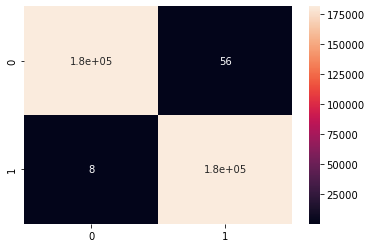

Accuracy:  0.999820950943313
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181514
           1       1.00      1.00      1.00    181515

    accuracy                           1.00    363029
   macro avg       1.00      1.00      1.00    363029
weighted avg       1.00      1.00      1.00    363029



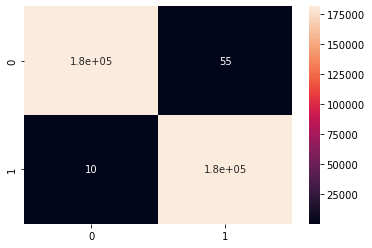

In [49]:
# train a knn classifier on the data to see how well it can predict leak probability
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# define the number of folds
k = 5

# split x and y
X = detection_input.drop(columns=['leak_probability'])
y = detection_input['leak_probability']

# implement SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# create a KFold object
kf = StratifiedShuffleSplit(n_splits=k, random_state=None)

# remeber best model
best_model = None
best_model_accuracy = 0

# split the data into k folds
for train_index, test_index in kf.split(X, y):
    # get the training and testing data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train the decision tree classifier on the training data
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = clf.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    if accuracy > best_model_accuracy:
        best_model = clf
        best_model_accuracy = accuracy

    # print the classification report
    print(classification_report(y_test, y_pred))

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

In [50]:
# pickle the model
import pickle
filename = 'knn_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [51]:
# drop weather columns
detection_input = detection_input.drop(columns=['temperature', 'humidity', 'pressure', 'wind_direction', 'wind_speed'])

Accuracy:  0.5014172421486989
              precision    recall  f1-score   support

           0       0.88      0.00      0.01    181514
           1       0.50      1.00      0.67    181515

    accuracy                           0.50    363029
   macro avg       0.69      0.50      0.34    363029
weighted avg       0.69      0.50      0.34    363029

Accuracy:  0.5015026347757342
              precision    recall  f1-score   support

           0       0.89      0.00      0.01    181514
           1       0.50      1.00      0.67    181515

    accuracy                           0.50    363029
   macro avg       0.69      0.50      0.34    363029
weighted avg       0.69      0.50      0.34    363029

Accuracy:  0.5013593955303847
              precision    recall  f1-score   support

           0       0.89      0.00      0.01    181514
           1       0.50      1.00      0.67    181515

    accuracy                           0.50    363029
   macro avg       0.69      0.50     

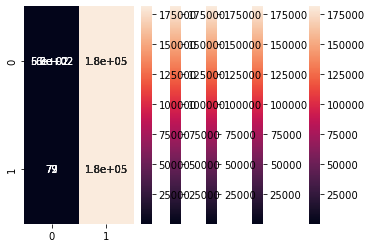

In [56]:
# train a naive bayes classifier on the data to see how well it can predict leak probability
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# define the number of folds
k = 5

# split x and y
X = detection_input.drop(columns=['leak_probability'])
y = detection_input['leak_probability']

# implement SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# create a KFold object
kf = StratifiedShuffleSplit(n_splits=k, random_state=None)

# remeber best model
best_model = None
best_model_accuracy = 0

# split the data into k folds
for train_index, test_index in kf.split(X, y):
    # get the training and testing data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train the decision tree classifier on the training data
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = clf.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    if accuracy > best_model_accuracy:
        best_model = clf
        best_model_accuracy = accuracy

    # print the classification report
    print(classification_report(y_test, y_pred))

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()
    



In [58]:
# pickle the model
import pickle
filename = 'naive_bayes_model_without_weather.sav'
pickle.dump(best_model, open(filename, 'wb'))
